# Modeling an orogenic system using FastScape: 2. Basic FastScape use

![Henry Mountains](HenryMountains.jpg "Henry Mountains")

## Using FastScape

Let's first import a few libraries that are essential to use FastScape

In [1]:
import xsimlab as xs # modeling framework used for FastScape development
import xarray as xr # xarray is a python package to work with labelled multi-dimensional arrays
import numpy as np # numpy is the basic numerical package in python
import matplotlib.pyplot as plt # matplotlib is the basic plotting package
#plt.style.use('dark_background')
%load_ext xsimlab.ipython

FastScape itself contains several model types, i.e. that include diffusion (or not), sediment transport/deposition (which we will use later), flexure, etc. Here we will use the *basic_model* which solves the equaiton described above, i.e., topographic evolution controlled by the balance between tectonic uplift, stream incision and hillslope diffusion.

In [2]:
from fastscape.models import basic_model


Let's look at it and compare its guts to the basic equation:

$$\frac{\partial h}{\partial t}=U-K_fA^mS^n+K_d\nabla^2h$$

domain definition:

$$x\in[0,L_x]$$ and $$y\in[0,L_y]$$

boundary conditions:

$$h(x=0, x=L_x, y=0, y=L_y)=0$$

and initial condition:

$$h(t=0) = rand(x,y)$$

In [3]:
basic_model.uplift

<BlockUplift 'uplift' (xsimlab process)>
Variables:
    rate           [in] () or ('y', 'x') uplift rate
    shape          [in] <--- grid.shape
    status         [in] <--- boundary.border_status
    fs_context     [in] <--- fs_context.context
    uplift        [out] () or ('y', 'x') imposed vertical uplift
Simulation stages:
    initialize
    run_step

We can also display the model graphically to examine its various components:

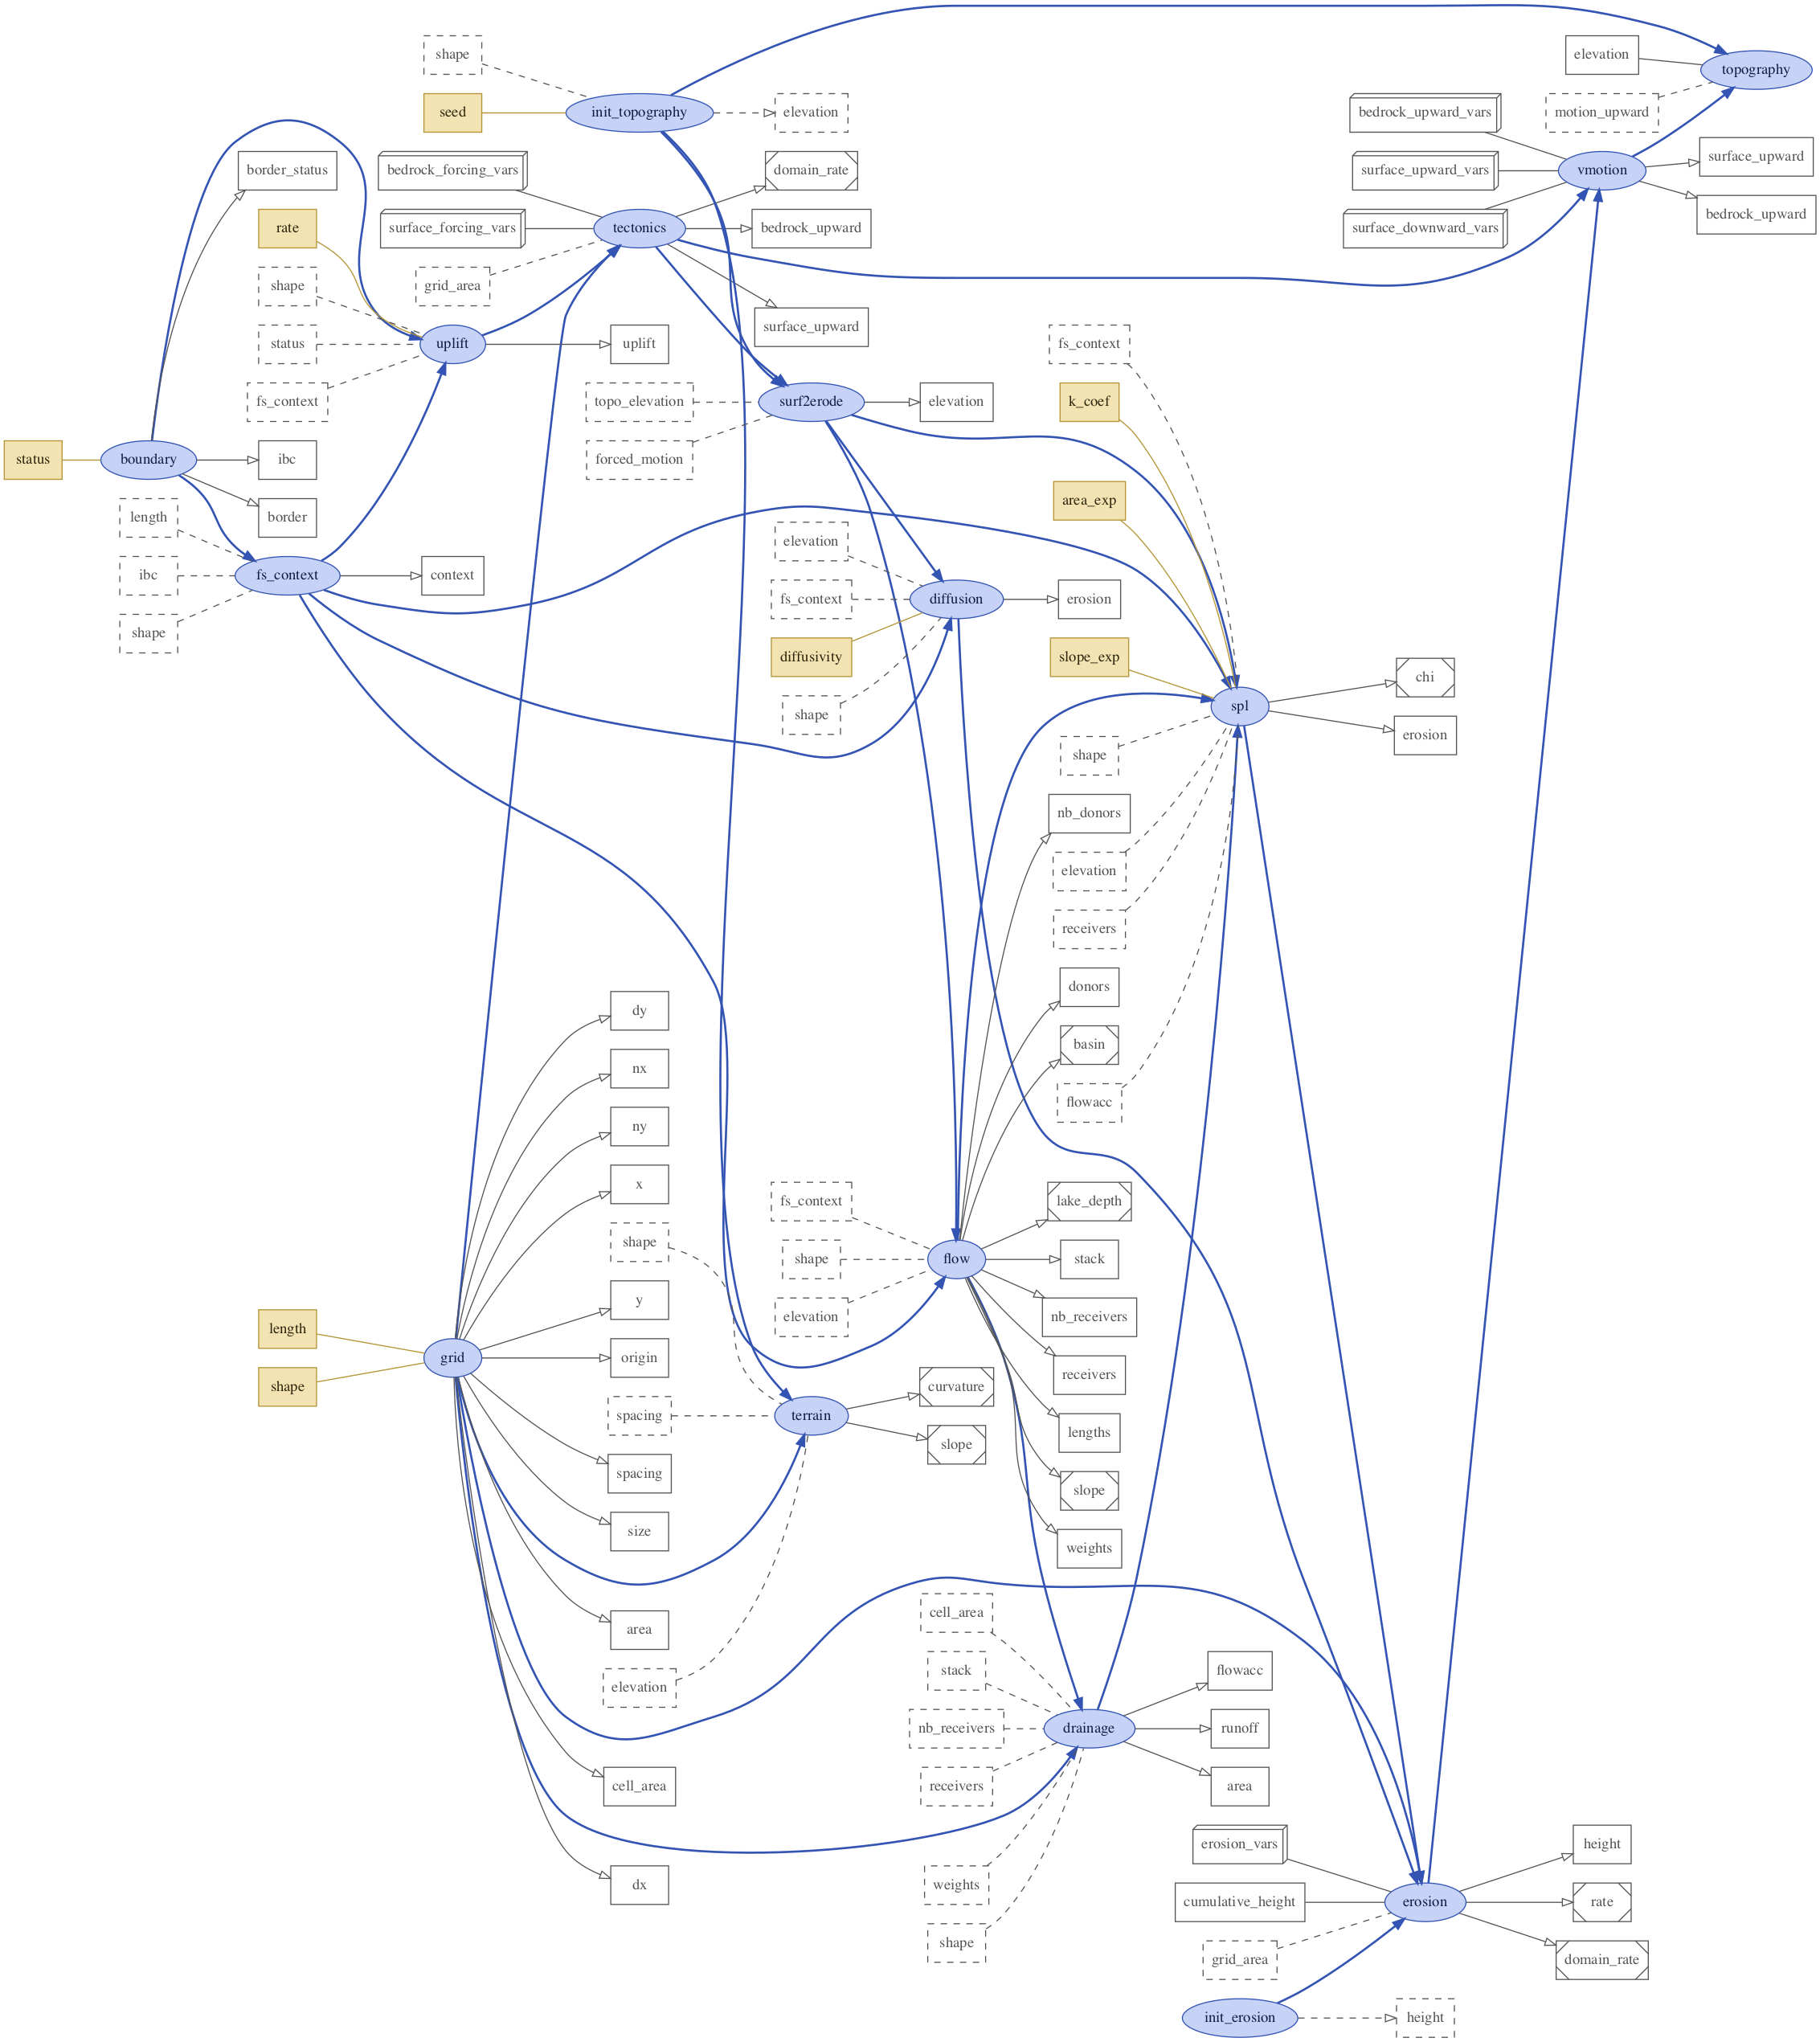

In [4]:
basic_model.visualize(show_variables=True)

To use FastScape, we need to specify the value of the input parameters. For this we use a functionality of the xsimlab package that create an input to the model with default or empty values for the various necessary parameters:

In [5]:
# %create_setup basic_model --default --verbose
import xsimlab as xs

ds_in = xs.create_setup(
    model=basic_model,
    clocks={'time': np.linspace(0,1e7,101)},
    master_clock='time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [101, 101],
        # total grid length in (y, x)
        'grid__length': [1e5, 1e5],
        # node status at borders
        'boundary__status': 'fixed_value',
        # uplift rate
        'uplift__rate': 1e-3,
        # bedrock channel incision coefficient
        'spl__k_coef': 1e-5,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # diffusivity (transport coefficient)
        'diffusion__diffusivity': 1e-2,
        # random seed
        'init_topography__seed': None,
    },

    output_vars={'topography__elevation': 'time'}
)


Let's now modify this setup to solve the following problem. We will assume that:
1. the uplifting region is 100$\times$100 km;
2. we will discretize it using 101$\times$101 nodes;
3. all boundary conditions are fixed (base level);
4. the uplift rate is 1 mm/yr;
5. $K_f=10^{-5}$, $K_d=10^{-2}$, $m=0.4$ and $n=1$

We also need to define a *clock* that will determine the time steps at which we wish to compute the solution. Here, we will compute the solution at 101 time steps from 0 to 10 Myr.

Let's look at what is inside the model set up (which is an xarray dataset...)

In [6]:
ds_in

<xarray.Dataset>
Dimensions:                 (time: 101, shape_yx: 2)
Coordinates:
  * time                    (time) float64 0.0 1e+05 2e+05 ... 9.9e+06 1e+07
Dimensions without coordinates: shape_yx
Data variables:
    grid__shape             (shape_yx) int64 101 101
    grid__length            (shape_yx) float64 1e+05 1e+05
    boundary__status        <U11 'fixed_value'
    uplift__rate            float64 0.001
    spl__k_coef             float64 1e-05
    spl__area_exp           float64 0.4
    spl__slope_exp          int64 1
    diffusion__diffusivity  float64 0.01
    init_topography__seed   object None

Now we can run the model...

In [7]:
ds_in.xsimlab.run(model=basic_model)

<xarray.Dataset>
Dimensions:                 (border: 4, shape_yx: 2, time: 101, y: 101, x: 101)
Coordinates:
  * border                  (border) object 'left' 'right' 'top' 'bottom'
  * time                    (time) float64 0.0 1e+05 2e+05 ... 9.9e+06 1e+07
  * x                       (x) float64 0.0 1e+03 2e+03 ... 9.9e+04 1e+05
  * y                       (y) float64 0.0 1e+03 2e+03 ... 9.9e+04 1e+05
Dimensions without coordinates: shape_yx
Data variables:
    boundary__status        <U11 'fixed_value'
    diffusion__diffusivity  float64 0.01
    grid__length            (shape_yx) float64 1e+05 1e+05
    grid__shape             (shape_yx) int64 101 101
    init_topography__seed   float64 nan
    spl__area_exp           float64 0.4
    spl__k_coef             float64 1e-05
    spl__slope_exp          int64 1
    topography__elevation   (time, y, x) float64 0.9155 0.9445 ... 0.3049 0.9575
    uplift__rate            float64 0.001

We see that the model has run but nothing has really changed (i.e. no output has been stored). To save any output, we must decide on what needs to be saved. This is done by specifying *output_vars* in *ds_in*. To see what is available, explore the model and its processes. For example, the process *topography* contains the variable *elevation*, which can be accessed using a double underscore: *topography__elevation*:

In [8]:
basic_model.topography

<SurfaceTopography 'topography' (xsimlab process)>
Variables:
    elevation      [inout] ('y', 'x') surface topography elevation
    motion_upward     [in] <--- vmotion.surface_upward
Simulation stages:
    finalize_step

So add the output variable *topography__elevation* and a frequency set by the clock *time.

Let's run it again but noting that it is very useful to store the output in an other dataset so that it can be displayed...

In [9]:
ds_out = ds_in.xsimlab.run(model=basic_model)

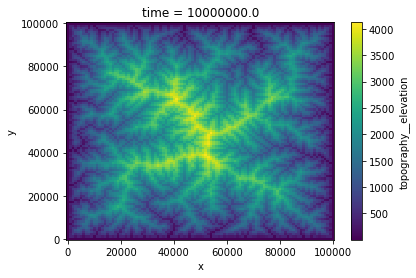

In [10]:
ds_out.topography__elevation.isel(time=-1).plot()

It is also useful to only store a sub-sample of time steps. For this, we can define another clock (*out*). Note that when more than one clock has been defined, one needs to specify which is the *master* clock... Tjis is what has been done in the following cell which by now should look similar/identical to the one you created above...

In [11]:
# %create_setup basic_model --default --verbose
import xsimlab as xs

ds_in = xs.create_setup(
    model=basic_model,
    clocks={'time': np.linspace(0,1e7,101),
           'out': np.linspace(0,1e7,11)},
    master_clock='time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [101, 101],
        # total grid length in (y, x)
        'grid__length': [1e5, 1e5],
        # node status at borders
        'boundary__status': 'fixed_value',
        # uplift rate
        'uplift__rate': 1e-3,
        # bedrock channel incision coefficient
        'spl__k_coef': 1e-5,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # diffusivity (transport coefficient)
        'diffusion__diffusivity': 1e-2,
        # random seed
        'init_topography__seed': None,
    },
    output_vars={'topography__elevation': 'out'}
)



Let's now run this new model.

It is also useful to use a progress bar, especially if the model run is long. For this we add another *decorator* to the basic run instruction

In [12]:
with xs.monitoring.ProgressBar():
    ds_out = ds_in.xsimlab.run(model=basic_model)

             0% | initialize 

We can now have a look at the solution. For this we use the *plot()* function that we apply to the *topography__elevation* variable after selection the last time step using *.isel(out=-1)*

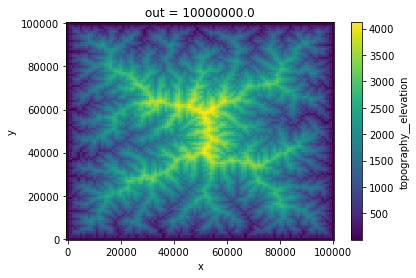

In [13]:
ds_out.topography__elevation.isel(out=-1).plot()

There are many ways to inspect/display the model results. You can use hvplot, for example:

You can also use a widget called TopoViz3D, part of ipyfastscape developed by Benoit Bovy, 

In [14]:
from ipyfastscape import TopoViz3d

app = TopoViz3d(ds_out, canvas_height=600, time_dim="out")

app.components['background_color'].set_color('lightgray')
app.components['vertical_exaggeration'].set_factor(5)
app.components['timestepper'].go_to_time(ds_out.out[-1])

app.show()

Output(layout=Layout(height='640px'))

The output can also be saved to many format, including *netcdf* which can be loaded into Paraview, for example...

In [15]:
ds_out.x.attrs["units"] = "m"
ds_out.y.attrs["units"] = "m"
ds_out.out.attrs["units"] = "years"
ds_out.topography__elevation.attrs["units"] = "m"

ds_out.topography__elevation.to_netcdf(path="./fastscape.nc")